# Models

In [59]:
# Get libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics 
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import pickle
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load data
df = pd.read_csv('C:/Users/User/Downloads/ds4a-secopII/SECOP_Electronicos_Cleaned.csv').drop(['NormalizedDelay','Unnamed: 0','Nombre Entidad','Dias Adicionados',
                                                                                                'Fecha de Inicio del Contrato', 'Fecha de Fin del Contrato'], axis=1)

In [4]:
df.columns

Index(['Departamento', 'Orden', 'Sector', 'Rama', 'Entidad Centralizada',
       'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
       'Es Grupo', 'Es Pyme', 'Obligación Ambiental',
       'Obligaciones Postconsumo', 'Valor del Contrato',
       'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Valor Amortizado', 'EsPostConflicto',
       'Destino Gasto', 'PGN', 'SGP', 'SGR', 'RP_AGR', 'RP_NO_AGR', 'RC',
       'Delay', 'Days_to_end_of_year'],
      dtype='object')

In [5]:
print('The shape of the dataset result of data cleaning is : ' + str(df.shape))

The shape of the dataset result of data cleaning is : (1565450, 27)


In [6]:
#Convert the variables to its corresponding data type
cat_cols = ['Departamento', 'Orden', 'Sector', 'Rama','Entidad Centralizada', 'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
            'Es Grupo','Es Pyme', 'Destino Gasto', 'EsPostConflicto','Obligaciones Postconsumo','Obligación Ambiental', 'Delay']
cat_values = {key:'category' for key in cat_cols}
df = df.astype(cat_values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565450 entries, 0 to 1565449
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Departamento               1565450 non-null  category
 1   Orden                      1565450 non-null  category
 2   Sector                     1565450 non-null  category
 3   Rama                       1565450 non-null  category
 4   Entidad Centralizada       1565450 non-null  category
 5   Estado Contrato            1565450 non-null  category
 6   Tipo de Contrato           1565450 non-null  category
 7   Modalidad de Contratacion  1565450 non-null  category
 8   Es Grupo                   1565450 non-null  category
 9   Es Pyme                    1565450 non-null  category
 10  Obligación Ambiental       1565450 non-null  category
 11  Obligaciones Postconsumo   1565450 non-null  category
 12  Valor del Contrato         1565450 non-null  int64   
 1

# Downsampling

The number of rows with Delay = 0 is : 1327318


New dataset after downsampling
0    331830
1    146544
2     67259
3     24329
Name: Delay, dtype: int64


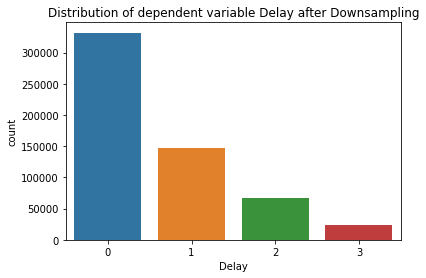



Dataset before downsampling
0    1327318
1     146544
2      67259
3      24329
Name: Delay, dtype: int64


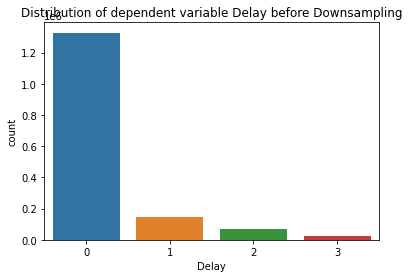

In [56]:
DelayZero_rows = len(df[df['Delay']==0])
print('The number of rows with Delay = 0 is : ' + str(DelayZero_rows))

# Rows to delete in downsampling
rows_to_delete = int(0.75*DelayZero_rows)

# Select all indices
candidate_indices = df[df['Delay']==0].index 

# Randomly Select 35% of all indices
candidate_indices = np.random.choice(candidate_indices, size = rows_to_delete, replace = False) 
df_DownSampling = df.drop(candidate_indices)

print('\n')
print('New dataset after downsampling')
print(df_DownSampling.Delay.value_counts())

#Bar plot of DownSampling dataset
sns.countplot(df_DownSampling.Delay)
plt.title('Distribution of dependent variable Delay after Downsampling')
plt.show()

print('\n')
print('Dataset before downsampling')
print(df.Delay.value_counts())

#Bar plot of df.Delay.value_counts()
sns.countplot(df.Delay)
plt.title('Distribution of dependent variable Delay before Downsampling')
plt.show()

# XGBoost

In [8]:
# Get X and Y variables

#Normal Dataset
y = df['Delay'].astype('category')
X = df.drop(['Delay'], axis=1)

#Downsampled Dataset
y = df_DownSampling['Delay'].astype('category')
X = df_DownSampling.drop(['Delay'], axis=1)


In [9]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Tuning XGBoost model

In [63]:
# This cell was run in the Virtual Machine

# Creation of list of values to iterate over different values of n_estimators
estimator_range = range(17,26,1)

# List to store the results.
f1_scores_LR = []

# Tuning of the model - THIS CELL TAKES TIME TO RUN
for estimator in estimator_range:
    clf = XGBClassifier(tree_method="hist", enable_categorical=True, learning_rate = (estimator*0.05))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1_scores_LR.append(metrics.f1_score(y_pred, y_test, average= 'macro'))

The best value of Learning Rate is : 21


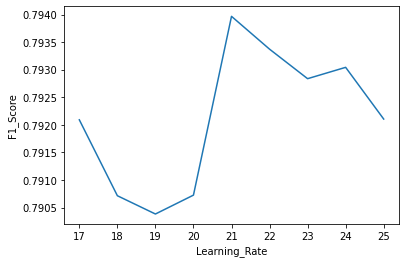

In [85]:
# Plotting the results
plt.plot(estimator_range, f1_scores_LR)
plt.xlabel('Learning_Rate')
plt.ylabel('F1_Score')
## The optimal learning rate is 21 * 0.05
print('The best value of Learning Rate is : ' + str(np.argmax(f1_scores_LR)+17))

### Best Model - Learning Rate

In [16]:
# Picking the best model of the previous cell
clf = XGBClassifier(tree_method="hist", enable_categorical=True, learning_rate = (21*0.05))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('\n')
print('The value of the F1 Score for XGBoost model tuning Learning rate is: ' + str(metrics.f1_score(y_pred, y_test, average= 'macro')))



The value of the F1 Score for XGBoost model tuning Learning rate is: 0.790764825093489


### Tuning XGBoost model - n_estimators, max_depth, learning_rate

In [47]:
# Parameter for Tuning
estimator_range = range(28,34, 1) 
depth_range = range(12,18, 1)
learning_range = range(12,18,1)


# Dictionary to store the results
f1_scores = {(i,j,k):0 for i in estimator_range for j in depth_range for k in learning_range}

In [48]:
# Tuning
for estimator in estimator_range:
    for depth in depth_range:
        for rate in learning_range:
            clf = XGBClassifier(n_estimators=estimator, max_depth=depth, learning_rate = (rate*0.05), tree_method="hist", enable_categorical=True)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores[estimator, depth, rate] = metrics.f1_score(y_pred, y_test, average= 'macro')

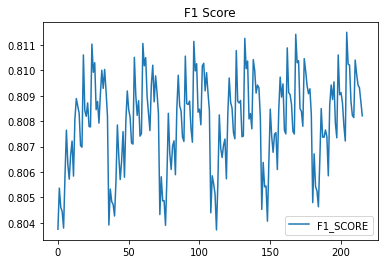

,0,1,2,F1_SCORE
204,33,16,12,0.811505
168,32,16,12,0.811424
132,31,16,12,0.811265
96,30,16,12,0.811144
60,29,16,12,0.811064
...,...,...,...,...
36,29,12,12,0.803912
76,30,12,16,0.803901
4,28,12,16,0.803790
0,28,12,12,0.803747


In [49]:
# Plotting the results
pl = (f1_scores.values())
pl = pd.DataFrame(pl).rename(columns={0: 'F1_SCORE'})
pa = (f1_scores.keys())
pa = pd.DataFrame(pa)
pd.DataFrame(pl).rename(columns={0: 'F1_SCORE'}).plot(kind='line', title='F1 Score')
plt.show()
sort_roc = pd.concat([pa, pl], axis=1)
sort_roc.sort_values(by=['F1_SCORE'], ascending=False)

### Best model

In [57]:
# Picking the best model of the previous cell
clf = XGBClassifier(n_estimators=33, max_depth=16, learning_rate = (12*0.05) , tree_method="hist", enable_categorical=True)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test, average= 'macro')
print('\n')
print('The value of the F1 Score for the 3 parameters tuned is: ' + str(metrics.f1_score(y_pred, y_test, average= 'macro')))

print(' THIS IS OUR WINNER MODEL ')



The value of the F1 Score for the 3 parameters tuned is: 0.8110779052067383
 THIS IS OUR WINNER MODEL 


## Feature importance 

The following plot shows the importance of each variable for the final prediction

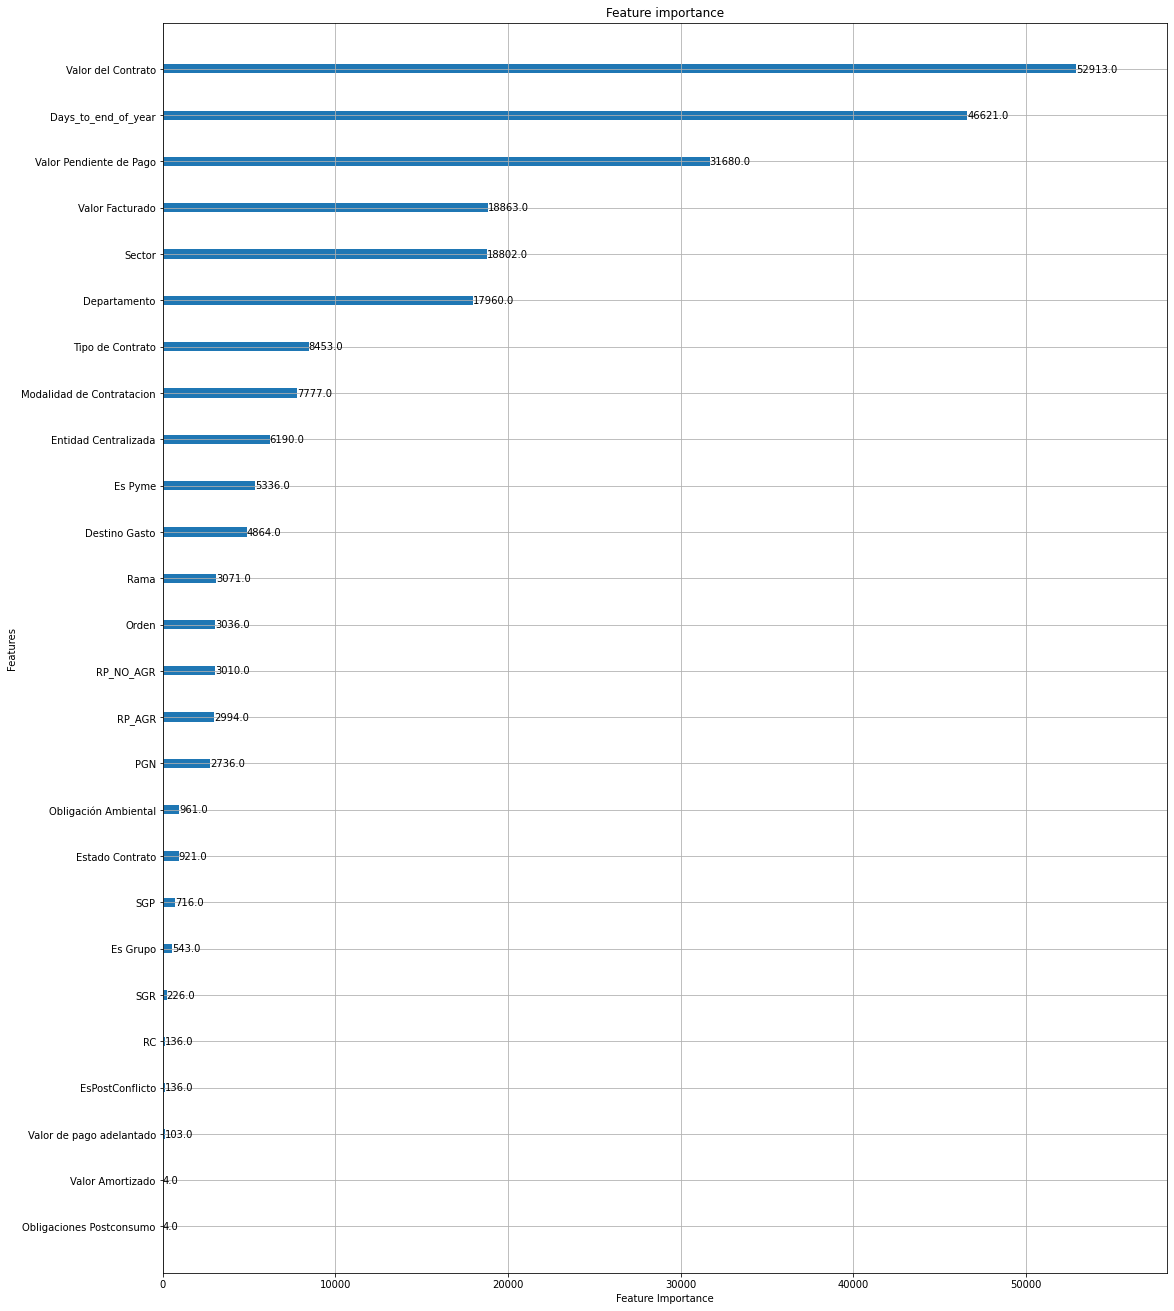

In [85]:
plot_importance(clf)
plt.rcParams["figure.figsize"] = [18,23]
plt.xlabel('Feature Importance')
plt.show()

### Generate .pkl file for predicting with the app

In [84]:
pickle.dump(clf, open('model_downsampling.pkl', 'wb'))

# Random Forest

In [66]:
#Downsampled Dataset
y = df_DownSampling['Delay'].astype('category')
X = df_DownSampling.drop(['Delay'], axis=1)
X.columns

Index(['Departamento', 'Orden', 'Sector', 'Rama', 'Entidad Centralizada',
       'Estado Contrato', 'Tipo de Contrato', 'Modalidad de Contratacion',
       'Es Grupo', 'Es Pyme', 'Obligación Ambiental',
       'Obligaciones Postconsumo', 'Valor del Contrato',
       'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Valor Amortizado', 'EsPostConflicto',
       'Destino Gasto', 'PGN', 'SGP', 'SGR', 'RP_AGR', 'RP_NO_AGR', 'RC',
       'Days_to_end_of_year'],
      dtype='object')

In [18]:
#Coding the existing categorical variables
X.Departamento = X.Departamento.cat.codes
X.Orden = X.Orden.cat.codes
X.Sector = X.Sector.cat.codes
X.Rama = X.Rama.cat.codes
X['Entidad Centralizada'] = X['Entidad Centralizada'].cat.codes
X['Estado Contrato'] = X['Estado Contrato'].cat.codes
X['Tipo de Contrato'] = X['Tipo de Contrato'].cat.codes
X['Modalidad de Contratacion'] = X['Modalidad de Contratacion'].cat.codes
X['Es Grupo'] = X['Es Grupo'].cat.codes
X['Es Pyme'] = X['Es Pyme'].cat.codes
X['Destino Gasto'] = X['Destino Gasto'].cat.codes
X['EsPostConflicto'] = X['EsPostConflicto'].cat.codes
X['Obligaciones Postconsumo'] = X['Obligaciones Postconsumo'].cat.codes
X['Obligación Ambiental'] = X['Obligación Ambiental'].cat.codes

In [19]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Tuning Random Forest Model - This cell takes time to run

In [ ]:
# Parameters for tunning
estimator_range = range(10, 310, 10)
max_range = range(5, X_train.shape[1], 1)

# Define dictionaty to store the results of each model
f1_scores = {(i,j):0 for i in estimator_range for j in max_range}

""" for estimator in estimator_range:
        for feature in max_range:
            clf = RandomForestClassifier(n_estimators=estimator, max_features=feature, n_jobs=-1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores[estimator, feature] = metrics.f1_score(y_pred, y_test, average= 'macro')""" 

In [ ]:
# Plotting the results
pl = (f1_scores.values())
pl = pd.DataFrame(pl).rename(columns={0: 'F1_SCORE'})
pa = (f1_scores.keys())
pa = pd.DataFrame(pa)
pd.DataFrame(pl).rename(columns={0: 'F1_SCORE'}).plot(kind='line', title='F1 Score')
plt.show()
sort_roc = pd.concat([pa, pl], axis=1)
sort_roc.sort_values(by=['F1_SCORE'], ascending=False)

#### This procedure was done in the virtual machine.

The best parameters were n_estimators = 170 and max_features = 11

### Best model Random Forest tuned

In [21]:
# Pick the best model of the previous cell
clf_Random_Forest = RandomForestClassifier(n_estimators = 170, max_features = 11)
predicts_RF = clf_Random_Forest.fit(X_train, y_train).predict(X_test)
print('The value of F1_Score for Random forest model tuned is: ' + str(metrics.f1_score(y_test, predicts_RF, average= 'macro')))

The value of F1_Score for Random forest model tuned is: 0.8066875281240975


# LightGBM Model

In [22]:
# Get X and Y variables

#Downsampled Dataset
y = df_DownSampling['Delay'].astype('category')
X = df_DownSampling.drop(['Delay'], axis=1)

In [23]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=1000, max_depth=6,random_state=42, learning_rate=0.05)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print('The value of F1_Score for Basic LightGBM model is: ' + str(metrics.f1_score(y_test, y_pred, average= 'macro')))

The value of F1_Score for Basic LightGBM model is: 0.7853796717391416


### Tuning LightGBM model

In [25]:
# Creation of list of values to iterate over different values of n_estimators
estimator_range = np.arange(0.05,0.2,0.01)
# List to store the results.
f1_scores_LR = []

for estimator in estimator_range:
    clf = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=1000, max_depth=6,random_state=42, learning_rate=estimator)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1_scores_LR.append(metrics.f1_score(y_pred, y_test, average= 'macro'))


The best value of Learning Rate is : 0.14


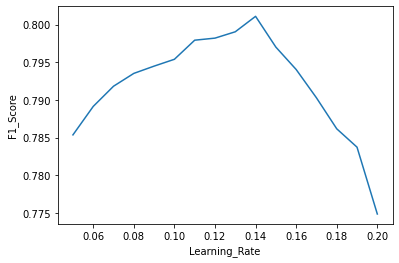

In [31]:
# Plotting the results
plt.plot(estimator_range, f1_scores_LR)
plt.xlabel('Learning_Rate')
plt.ylabel('F1_Score')
print('The best value of Learning Rate is : ' + str(0.14))

### Best Model - Learning Rate

In [30]:
# Picking the best model of the previous cell
clf = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=1000, max_depth=6,random_state=42, learning_rate=0.14)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print('The value of the F1 Score for LightGBM Model tuning the Learning rate is: ' + str(metrics.f1_score(y_pred, y_test, average= 'macro')))

The value of the F1 Score for LightGBM Model tuning the Learning rate is: 0.8010830745103897


# Model Comparison

In [33]:
# Performance of each model
Best_Xgboost = 0.8111
Best_RandomF = 0.8066
Best_LightGBM = 0.8011
Best_NeuralNetwork = 0.66


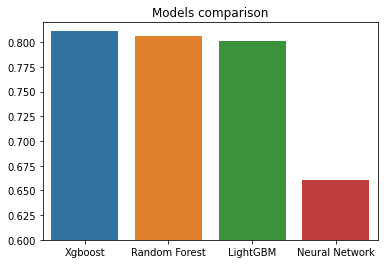

In [51]:
barchart = [Best_Xgboost, Best_RandomF,Best_LightGBM, Best_NeuralNetwork]
#Seaborn bar plot with barchart variable
sns.barplot(x=['Xgboost', 'Random Forest', 'LightGBM', 'Neural Network'], y=barchart)
plt.gca().set_ylim(0.6, 0.82)
#set plot title
plt.title('Models comparison')
plt.show()

The best model is XGBoost followed by Random Forest and LightGBM respectively. Finally we have the Neural Network